### Imports

In [1]:
import tensorflow as tf

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import gpflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Read file

In [4]:
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_birmingham_report_df_norm')

In [5]:
clean_birmingham_report_df_norm

site_name site_id          report_date time_period_ending  \
0         M42/6482L     175  2019-03-19T00:00:00           00:14:00   
1         M42/6482L     175  2019-03-19T00:00:00           00:29:00   
2         M42/6482L     175  2019-03-19T00:00:00           00:44:00   
3         M42/6482L     175  2019-03-19T00:00:00           00:59:00   
4         M42/6482L     175  2019-03-19T00:00:00           01:14:00   
...             ...     ...                  ...                ...   
2671410  M42/6420M2   10790  2022-04-08T00:00:00           22:59:00   
2671411  M42/6420M2   10790  2022-04-08T00:00:00           23:14:00   
2671412  M42/6420M2   10790  2022-04-08T00:00:00           23:29:00   
2671413  M42/6420M2   10790  2022-04-08T00:00:00           23:44:00   
2671414  M42/6420M2   10790  2022-04-08T00:00:00           23:59:00   

        time_interval  0-520cm  521-660cm  661-1160cm  1160+cm avg_mph  \
0                   0       19          4           8       18      62   
1                   1        7          4           8       17      57   
2                   2       13          3           5        8      61   
3                   3       17          2           4       20      59   
4                   4       15          6          12       16      61   
...               ...      ...        ...         ...      ...     ...   
2671410            91       18          3           2        3      53   
2671411            92       29          3           1        1      55   
2671412            93       30          3           0        1      55   
2671413            94       10          2           0        0      53   
2671414            95       11          4           0        1      56   

         total_volume           timestamp  0-520cm_normalised  \
0                  49 2019-03-19 00:14:00            0.154378   
1                  36 2019-03-19 00:29:00            0.056876   
2                  29 2019-03-19 00:44:00            0.105627   
3                  43 2019-03-19 00:59:00            0.138127   
4                  49 2019-03-19 01:14:00            0.121877   
...               ...                 ...                 ...   
2671410            26 2022-04-08 22:59:00            0.438145   
2671411            34 2022-04-08 23:14:00            0.705900   
2671412            34 2022-04-08 23:29:00            0.730241   
2671413            12 2022-04-08 23:44:00            0.243414   
2671414            16 2022-04-08 23:59:00            0.267755   

         521-660cm_normalised  661-1160cm_normalised  1160+cm_normalised  \
0                    0.126290               0.539276            1.035132   
1                    0.126290               0.539276            0.977625   
2                    0.094717               0.337048            0.460059   
3                    0.063145               0.269638            1.150147   
4                    0.189435               0.808914            0.920117   
...                       ...                    ...                 ...   
2671410              0.218674               0.617148            3.270125   
2671411              0.218674               0.308574            1.090042   
2671412              0.218674               0.000000            1.090042   
2671413              0.145782               0.000000            0.000000   
2671414              0.291565               0.000000            1.090042   

         total_volume_normalised  float_time  
0                       0.262072     66.5364  
1                       0.192543     66.5454  
2                       0.155104     66.5544  
3                       0.229982     66.5634  
4                       0.262072     66.5724  
...                          ...         ...  
2671410                 0.440961   1031.5794  
2671411                 0.576641   1031.5884  
2671412                 0.576641   1031.5974  
2671413                 0.203520   1031.6064  
2671414                 0.271360   1031.6154  

[2671415 

In [6]:
clean_birmingham_report_df_norm.site_name.unique()

array(['M42/6482L', 'M42/6473B', 'M42/6468A', 'M6/5711L', 'M6/5732B',
       'M42/6472A', 'M6/5722A', 'M42/6467K', 'M42/6482B', 'M6/5737A',
       'M6/5733A', '7642/1', '7642/2', '7132/1', '7133/1', 'M6/5717L',
       'M42/6438A', 'M42/6428K', 'M42/6457A', 'M42/6420M1', 'M42/6430L',
       'M42/6420B', 'M42/6457J', 'M42/6456M1', 'M42/6456M2', 'M42/6420M2'],
      dtype=object)

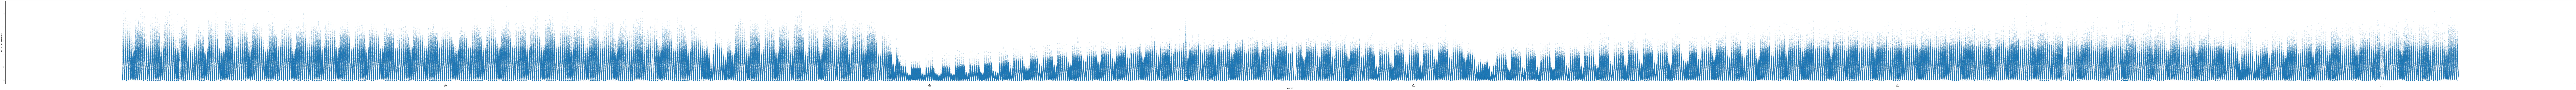

In [17]:
fig, ax = plt.subplots(figsize=(300,10))
clean_birmingham_report_df_norm.plot('float_time','total_volume_normalised', ax=ax, kind = 'scatter', alpha = 0.1)
plt.savefig('birmingham.png', dpi=100)
plt.show()

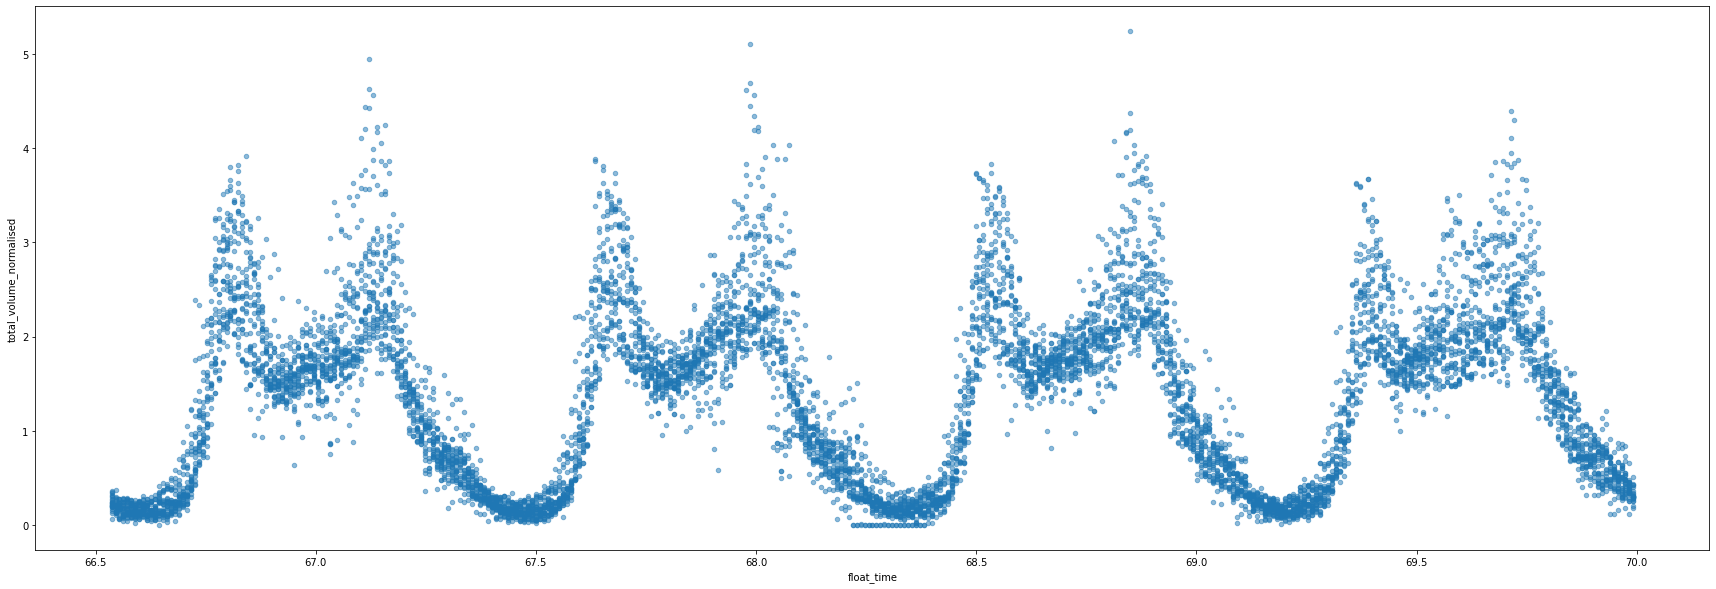

In [9]:
small_slice = clean_birmingham_report_df_norm[clean_birmingham_report_df_norm.float_time < 70]

fig, ax = plt.subplots(figsize=(30,10))
small_slice.plot('float_time','total_volume_normalised', ax=ax, kind = 'scatter', alpha = 0.5)
plt.show()

### Peroids

In [10]:
quarter_hour = 9e-3
hour = 4*quarter_hour
day = 24*hour
week = 7*day

In [52]:
len(small_slice)

9240

### Small slice GP

In [16]:
from gpflow.ci_utils import ci_niter

In [38]:
X = np.array(small_slice.float_time).reshape(-1,1)
Y = np.array(small_slice.total_volume_normalised).reshape(-1,1)
Y_mean = Y.mean()
Y = Y- Y_mean

In [39]:
N = len(X)
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

In [66]:
M = 200  # Number of inducing locations
Z = np.random.choice(X.reshape(-1),M).reshape(-1,1)
kernel = gpflow.kernels.SquaredExponential()
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

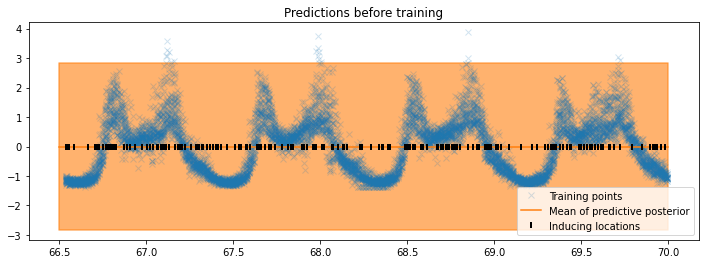

In [67]:
def plot(title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(66.5, 70, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, "x", label="Training points", alpha=0.2)
    (line,) = plt.plot(pX, pY, lw=1.5, label="Mean of predictive posterior")
    col = line.get_color()
    plt.fill_between(
        pX[:, 0],
        (pY - 2 * pYv ** 0.5)[:, 0],
        (pY + 2 * pYv ** 0.5)[:, 0],
        color=col,
        alpha=0.6,
        lw=1.5,
    )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Inducing locations")
    plt.legend(loc="lower right")


plot(title="Predictions before training")

In [57]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            if step % round(iterations/100) == 0:
                tf.print(f"iteration {step} of {iterations}")
    return logf

In [44]:
maxiter = ci_niter(20000)

logf = run_adam(m, maxiter)

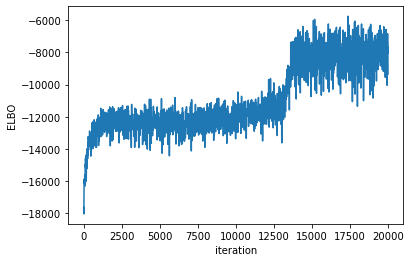

In [45]:
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

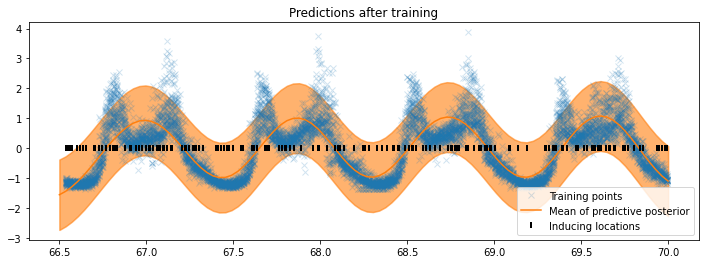

In [46]:
plot("Predictions after training")

### Larger Batches

In [53]:
 ci_niter(20000)

20000

iteration 0 of 8000
iteration 80 of 8000
iteration 160 of 8000
iteration 240 of 8000
iteration 320 of 8000
iteration 400 of 8000
iteration 480 of 8000
iteration 560 of 8000
iteration 640 of 8000
iteration 720 of 8000
iteration 800 of 8000
iteration 880 of 8000
iteration 960 of 8000
iteration 1040 of 8000
iteration 1120 of 8000
iteration 1200 of 8000
iteration 1280 of 8000
iteration 1360 of 8000
iteration 1440 of 8000
iteration 1520 of 8000
iteration 1600 of 8000
iteration 1680 of 8000
iteration 1760 of 8000
iteration 1840 of 8000
iteration 1920 of 8000
iteration 2000 of 8000
iteration 2080 of 8000
iteration 2160 of 8000
iteration 2240 of 8000
iteration 2320 of 8000
iteration 2400 of 8000
iteration 2480 of 8000
iteration 2560 of 8000
iteration 2640 of 8000
iteration 2720 of 8000
iteration 2800 of 8000
iteration 2880 of 8000
iteration 2960 of 8000
iteration 3040 of 8000
iteration 3120 of 8000
iteration 3200 of 8000
iteration 3280 of 8000
iteration 3360 of 8000
iteration 3440 of 8000
iter

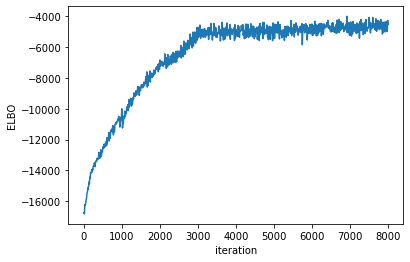

In [68]:
kernel = gpflow.kernels.SquaredExponential()
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
minibatch_size = 2000

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)

plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

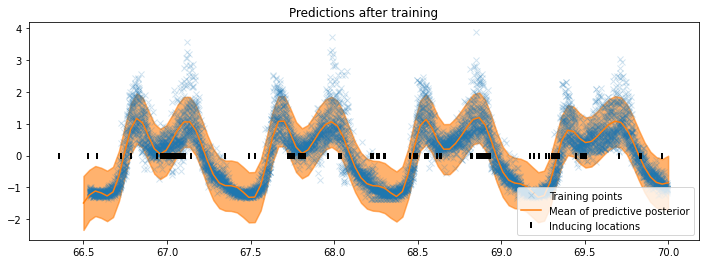

In [69]:
plot("Predictions after training")

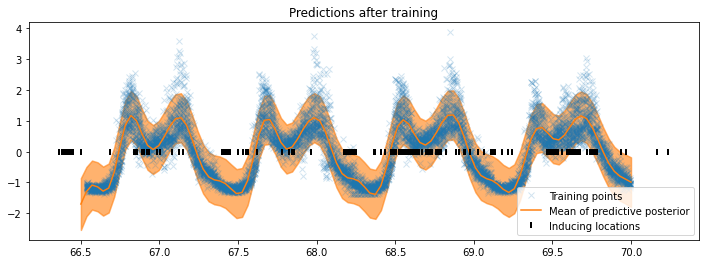

In [65]:
plot("Predictions after training")

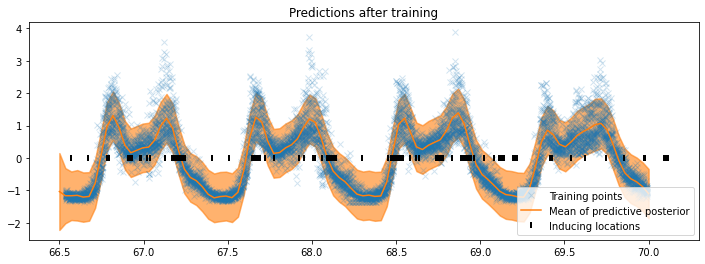

In [61]:
plot("Predictions after training")